In [24]:
import pandas as pd
import joblib
import pickle
import os

# Load our best model (Random Forest) that we identified during evaluation.
best_model = joblib.load("../models/lightgbm.pkl")

# We also need the list of features the model expects to see.
with open("../data/processed/selected_features.pkl", 'rb') as f:
    selected_features = pickle.load(f)

print("Best model and feature list have been loaded.")

Best model and feature list have been loaded.


In [28]:
def classify_traffic(raw_data_row, model):
    """
    Takes a single row of raw traffic data (as a DataFrame)
    and returns a prediction ('BENIGN' or 'ATTACK').
    
    The model's internal pipeline will handle any necessary imputation or scaling.
    """
    # The .predict() command runs the entire pipeline and makes a prediction.
    prediction_numeric = model.predict(raw_data_row)
    
    # Convert the numeric prediction back to a human-readable label
    prediction_label = 'BENIGN' if prediction_numeric[0] == 0 else 'ATTACK'
    
    return prediction_label

In [ ]:
# Here is a sample of new, raw data as a dictionary.
# In a real application, this would come from a network sensor.
new_sample = {
    'Flow Duration': [51234], 'Total Fwd Packets': [2], 'Total Backward Packets': [0],
    'Total Length of Fwd Packets': [12], 'Total Length of Bwd Packets': [0],
    'Fwd Packet Length Max': [6], 'Fwd Packet Length Min': [6],
    'Fwd Packet Length Mean': [6.0], 'Fwd Packet Length Std': [0.0],
    'Bwd Packet Length Max': [0], 'Bwd Packet Length Min': [0],
    'Bwd Packet Length Mean': [0.0], 'Bwd Packet Length Std': [0.0],
    'Flow Bytes/s': [234.21], 'Flow Packets/s': [39.03], 'Flow IAT Mean': [51234.0],
    'Flow IAT Std': [0.0], 'Flow IAT Max': [51234], 'Flow IAT Min': [51234],
    'Fwd IAT Total': [51234.0], 'Fwd IAT Mean': [51234.0], 'Fwd IAT Std': [0.0],
    'Fwd IAT Max': [51234], 'Fwd IAT Min': [51234],
    'Bwd IAT Total': [0], 'Bwd IAT Mean': [0.0], 'Bwd IAT Std': [0.0],
    'Bwd IAT Max': [0], 'Bwd IAT Min': [0],
    'Fwd PSH Flags': [0], 'Bwd PSH Flags': [0], 'Fwd URG Flags': [0], 'Bwd URG Flags': [0],
    'Fwd Header Length': [40], 'Bwd Header Length': [0], 'Fwd Packets/s': [39.03],
    'Bwd Packets/s': [0.0], 'Min Packet Length': [6], 'Max Packet Length': [6],
    'Packet Length Mean': [6.0], 'Packet Length Std': [0.0], 'Packet Length Variance': [0.0],
    'FIN Flag Count': [0], 'SYN Flag Count': [0], 'RST Flag Count': [0],
    'PSH Flag Count': [1], 'ACK Flag Count': [0], 'URG Flag Count': [0],
    'CWE Flag Count': [0], 'ECE Flag Count': [0], 'Down/Up Ratio': [0],
    'Average Packet Size': [9.0], 'Avg Fwd Segment Size': [6.0], 'Avg Bwd Segment Size': [0.0],
    'Fwd Header Length.1': [40], 'Fwd Avg Bytes/Bulk': [0], 'Fwd Avg Packets/Bulk': [0],
    'Fwd Avg Bulk Rate': [0], 'Bwd Avg Bytes/Bulk': [0], 'Bwd Avg Packets/Bulk': [0],
    'Bwd Avg Bulk Rate': [0], 'Subflow Fwd Packets': [2], 'Subflow Fwd Bytes': [12],
    'Subflow B}

SyntaxError: unterminated string literal (detected at line 27) (274812263.py, line 27)

In [25]:
import numpy as np

def preprocess_dataframe(df):
    """Applies the same cleaning and encoding steps used during training."""
    df_processed = df.copy()
    df_processed.columns = df_processed.columns.str.strip()
    
    # We encode the label here to compare our model's prediction to the actual result.
    df_processed['Label'] = df_processed['Label'].apply(
        lambda x: 0 if isinstance(x, str) and x.strip().upper() == 'BENIGN' else 1
    )
    
    # These columns are identifiers and aren't useful for the model.
    drop_cols = ['Flow ID', 'Timestamp', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Protocol']
    df_processed.drop(columns=[col for col in drop_cols if col in df_processed.columns], inplace=True, errors='ignore')

    # Remove any other non-numeric columns.
    non_numeric = df_processed.select_dtypes(include=['object']).columns
    df_processed.drop(columns=non_numeric, inplace=True)

    # Standardize infinite values to NaN so they can be handled.
    df_processed.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_processed.dropna(inplace=True)

    return df_processed

In [26]:
import glob

# Define the path to the inference files.
inference_path = "../data/InferenceDataset/"

# Find all CSV files in that directory.
friday_files = glob.glob(os.path.join(inference_path, "*.csv"))
print(f"Found {len(friday_files)} files to merge for inference.")

# Read and merge them into a single dataframe.
inference_df_raw = pd.concat(
    [pd.read_csv(f) for f in friday_files],
    ignore_index=True
)
print(f"Loaded and merged raw inference data with {inference_df_raw.shape[0]} rows.")

Found 3 files to merge for inference.
Loaded and merged raw inference data with 703245 rows.


Overall Accuracy on Inference Data (Friday): 0.7007

Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.66      0.99      0.80    413933
      ATTACK       0.97      0.28      0.44    288785

    accuracy                           0.70    702718
   macro avg       0.82      0.64      0.62    702718
weighted avg       0.79      0.70      0.65    702718

Confusion Matrix:


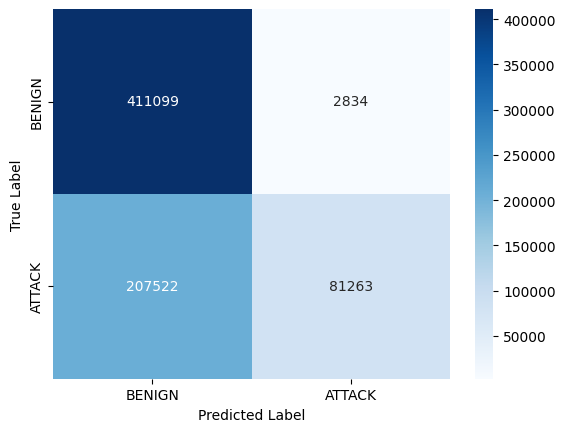

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# First, clean the entire Friday dataset using our function.
inference_clean_df = preprocess_dataframe(inference_df_raw)

# Separate the features from the true labels.
X_inference = inference_clean_df.drop('Label', axis=1)
y_actual = inference_clean_df['Label']

# Filter the columns to match exactly what the model was trained on.
X_inference_final = X_inference[selected_features]

# Now, make predictions on all the new data.
predictions = best_model.predict(X_inference_final)

# Finally, let's see how it did.
accuracy = accuracy_score(y_actual, predictions)
print(f"Overall Accuracy on Inference Data (Friday): {accuracy:.4f}\n")

# The classification report gives a detailed breakdown of performance for each class.
print("Classification Report:")
print(classification_report(y_actual, predictions, target_names=['BENIGN', 'ATTACK']))

# The confusion matrix gives a clear visual of the model's mistakes.
print("Confusion Matrix:")
cm = confusion_matrix(y_actual, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['BENIGN', 'ATTACK'], yticklabels=['BENIGN', 'ATTACK'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()